In [1]:
include("optimization_library.jl");
include("mplstyle.jl");

# Exercise 6.2c: Paint production rates

What are the daily production rates of interior and exterior paint that maximize the company's revenue? Find the optimal solution using the interior point method.

Canonical form of the optimization problem:
\begin{align}
\text{minimize}\quad & -2x_1 - 3 x_2\\
\text{subject to}\quad & x_1 - 2 \leq 0\\
& x_2 - 3 \leq 0\\
& 2x_1 + x_2 - 6 \leq 0\\
& x_1 + 2x_2 - 7 \leq 0
\end{align}

In [6]:
# ===============================================================================
# Solve the problem using the interior point method. Either use your own implemented function or the function ipm()
# from optimization_library.jl. Beware that the trace returned by the ipm() function from the library has been extended
# by one row which stores the number of newton iterations needed to find the next point x_k (see Exercise 5.1)
# on the central path.

# Create vectors that store the functions, gradients and hessian matrices for all contraints
num_const = 4
c = Vector(undef, num_const)
dc = Vector(undef, num_const)
Hc = Vector(undef, num_const)

f(x) = -2*x[1] - 3x[2]
df(x) = [-2;-3]
Hf(x) = zeros(2,2)

A = [1 0;
    0 1;
    2 1;
    1 2]

A = A[1:num_const,:]

b = [2,3,6,7]

b = b[1:num_const]

for i in 1:num_const
    c[i] = x -> LA.dot(A[i,:], x) - b[i]
    dc[i] = x-> A[i,:]
    Hc[i] = x-> zeros(2,2)
end

x0 = [-2,-1]

x_best, trace = ipm(f, df, Hf, x0; g=c, dg=dc, Hg=Hc,
            initial_barrier = 1.0, barrier_increase = 2.0, maxiters=100, inner_maxiters=100,
             ls=true, eps=0.0001);

println("Number of outer iterations: ", size(trace,2))
println("Total number of Newton iterations: ", sum(trace[end,:]))
println("Minimizer: ", x_best)
println("Maximized revenue: ", -f(x_best))
# ===============================================================================

Number of outer iterations: 16
Total number of Newton iterations: 37.0
Minimizer: [1.6664427056039564, 2.6667336706664293]
Maximized revenue: 11.3330864232072


In [7]:
# function for plotting the contour of objective function within feasible region
function feasible(x)
    result = NaN
    if sum(A *x - b .<= zeros(4)) == 4
        result = f(x)
    end
    return result
end

feasible (generic function with 1 method)

In [8]:
# plot the objective function and the feasible region

n_points = 50
x1_plot = range(minimum(trace[1,:])+minimum(trace[1,:])*0.5,maximum(trace[1,:])+maximum(trace[1,:])*0.5,length = n_points)
x2_plot = range(minimum(trace[2,:])+minimum(trace[2,:])*0.5,maximum(trace[2,:])+maximum(trace[2,:])*0.5,length = n_points)

f_plot = [f([x1,x2]) for x1 = x1_plot, x2 = x2_plot]

# create grid points
xgrid = repeat(x1_plot',n_points,1)
ygrid = repeat(x2_plot,1,n_points)

feasible_plot = [feasible([x1,x2]) for x1 = x1_plot, x2 = x2_plot]

# allow window to open for interactions
using3D()
pygui(true);
fig = figure("pyplot_surfaceplot",figsize=(15,10))
ax = fig.add_subplot(1,1,1,projection="3d")

    # plot loss function
plot_surface(xgrid', ygrid', f_plot, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.3, linewidth=0.25)
plot_surface(xgrid', ygrid', feasible_plot, rstride=2,edgecolors="k", cstride=2, alpha=0.3, linewidth=0.25)

# plot traces of gradient and newton descent
ax[:plot](trace[1,:], trace[2,:], trace[3,:], color="red", zorder = 3)
ax[:scatter](trace[1,:], trace[2,:], trace[3,:], color="red")

# contour of objective function within feasible region
ax[:contourf](xgrid', ygrid', feasible_plot, zdir="z", offset=-15)

zlim(-20,0)

fontsize = 15
xlabel(L"x_1", fontsize=fontsize)
ylabel(L"x_2", fontsize=fontsize)
zlabel(L"f(x)", fontsize=fontsize)

PyObject Text(0.09479538405482854, 0.01270017330184464, '$f(x)$')

In [9]:
trace[end-1,:].-f(x_best)

16-element Vector{Float64}:
 18.3330864232072
  3.2577006857013107
  1.403501206885423
  0.5878873495486534
  0.2756662131950822
  0.13219445573482425
  0.06546121439064834
  0.031200595282232513
  0.015712916207270666
  0.00749681953252157
  0.0037141939375544553
  0.0016819875868439027
  0.0007414028526913086
  0.00023498718184455925
  0.0
  0.0

# Exercise 6.2c: Trade off between inner and outer number of iterations

-11.3330864232072
-11.333285899231047
-11.33332949883188
-11.333333333333325


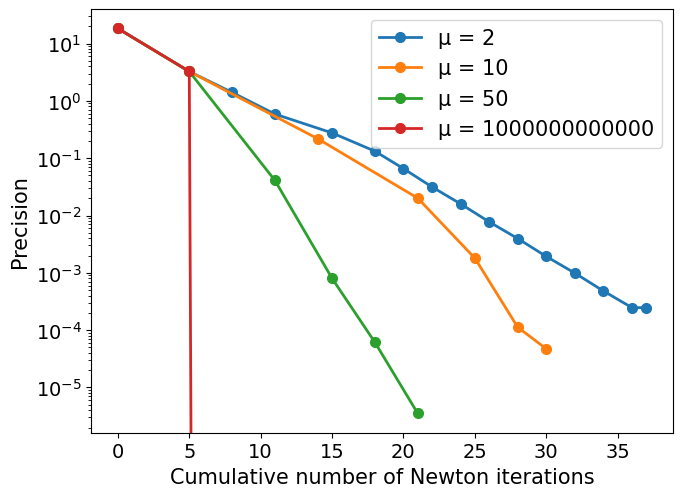

In [10]:
pygui(false);
μ = [2,10,50, 1000000000000] # values for barrier_increase

for mu in μ
# ===============================================================================
    # Solve the optimization problem for barrier_increase = mu
    # Plot the precision of the intermediate solutions (f(x_k) - f(x_optimum)) after each outer iteration versus the 
    # cumulative number of newton iterations needed in the inner iteration given by "accumulate(+, trace[end,:])".
    x_best, trace = ipm(f, df, Hf, x0; g=c, dg=dc, Hg=Hc, barrier_increase = mu);
    #plot(accumulate(+, trace[end,:]),trace[end-1,:].-f(x_best), marker = "o", label = "μ = $mu")
    plot(accumulate(+, trace[end,:]),trace[end-1,:].+11.33333301333324, marker = "o", label = "μ = $mu")
    println(f(x_best))
# ===============================================================================
end
    
xlabel("Cumulative number of Newton iterations", fontsize = fontsize)
ylabel("Precision", fontsize = fontsize)
legend(fontsize = fontsize)
yscale("log")

# Exercise 6.3a

In [11]:
# Find a valid admissible solution for the Interior Point Method
# x0: Initial point.
# g: Array of inequality constraints g_i(x) < 0
# dg: Array with the gradient of the inequality constraints
# maxiters: Maximum number of iterations
# eps: Minimum distance of the solution from the barrier

function ipm_admissible(x0; g=[], dg=[], initial_barrier = 1.0, barrier_increase = 2.0, maxiters = 100, 
        inner_maxiters = 100, eps=0.0001)
    
    glen = length(g)
    xlen = length(x0)

# ===============================================================================
    # 1. Find the initial s
    #    Add 10% of |max_i(g_i(x0))| to ensure that we start with an interior point
    s = maximum([g[i](x0) for i=1:glen])
    s += abs(s) * 0.1

    # 2. The optimization problem to be solved is "min_y s" for y = (x,s).
    f(y) = y[end]
    df(y) = [zeros(xlen); 1]

    # 3. Define the constraints with the slack variable s as follows: g_i(x) - s < 0
    gg = Vector(undef, glen)
    dgg = Vector(undef, glen)
    for i in 1:glen
        gg[i] = y -> g[i](y[1:end-1]) - y[end]
        dgg[i] = y -> [dg[i](y[1:end-1]); -1]
    end

    # 4. Use the interior point method to solve the optimization problem
    #    Stop the outer iterations as soon as an admissible solution has been found.
    #    Use gradient descent for the inner iterations in order to avoid very large hessians (due to small gradients)
    #    that cannot be inverted. Stop the outer loop if the solution x_k of the inner iteration is already an admissible
    #    point.

    barr = Vector(undef, glen)
    dbarr = Vector(undef, glen)
    for i in 1:glen
        barr[i],dbarr[i],_ = log_barrier(gg[i], dgg[i],nothing) # ignore the hessian
    end

    t = initial_barrier
    # Construct ftilde
    ftilde(x)  = f(x)  + sum([bb(x) for bb in barr]) / t
    dftilde(x) = df(x) + sum([dbb(x) for dbb in dbarr]) / t

    # Minimize ftilde
    # Stop when an admissible solution has been found.
    y = [x0; s]
    counter = 0
    trace_y = [y;ftilde(y)]
    for i=1:maxiters
        # Have an admissible solution
        if y[end] < -eps
            break
        end

        # Tighten the barrier
        t = t * barrier_increase
        y,trace = gradient_descent(ftilde, dftilde, y; ϵ=0.0001, maxiters = inner_maxiters, p = 2.0, ls = false)
        println("gradient:",LA.norm(dftilde(y)), "\ts:\t", y[end])
        if(size(trace,2) == inner_maxiters)
            println("Maximum number of inner iterations reached!")
        end
        counter = counter + 1
        
        if LA.norm(trace_y[1:end-1,end] - y) < eps
            "Interior Point Method converged."
            break
        end
        trace_y = hcat(trace_y, [y; ftilde(y)])

    end

    if(counter == maxiters)
        println("Maximum number of outer iterations reached!")
    end
    
    # 5. Notify the user if no admissible point could be found
    #    Note that the case s = 0 will in practice not hold due to numerical imprecisions. Use abs(s) <= eps instead!

    if abs(y[end]) <= eps
        error("Problem has an admissible solution, but no interior point")
    end

    # No admissible solution
    if y[end] > eps
        error("Problem has no admissible interior point")
    end

    # 6. Return the interior point
    return y[1:end-1], trace_y
# ===============================================================================
end;

# Exercise 6.3b

Verify your implementation by searching for an admissible point for the problem in Exercise 6.2 given the inadmissible point $\vec{x} = (100,100)$. Make sure your method really results in an admissible point.

In [12]:
# ===============================================================================
x0 = [100,100]

x_adm, trace = ipm_admissible(x0; g=c, dg=dc, maxiters = 100, eps=0.0001)
# ===============================================================================

gradient:0.8988586204157363	s:	156.05313192799628
gradient:0.6461857961280195	s:	-3.356409823982654


([-2.2517537657921527, -1.2517745091421042], [100.0 51.84165931244207 -2.2517537657921527; 100.0 52.77444147736419 -1.2517745091421042; 323.4 156.05313192799628 -3.356409823982654; 305.76438276930844 149.65947290216386 -4.365191280825297])

In [13]:
x_adm

2-element Vector{Float64}:
 -2.2517537657921527
 -1.2517745091421042

In [14]:
x_best, trace = ipm(f, df, Hf, x_adm; g=c, dg=dc, Hg=Hc,
            initial_barrier = 1.0, barrier_increase = 2.0, maxiters=100, inner_maxiters=100,
             ls=true, eps=0.0001);

println("Number of outer iterations: ", size(trace,2))
println("Total number of Newton iterations: ", sum(trace[end,:]))
println("Minimizer: ", x_best)
println("Maximized revenue: ", -f(x_best))

Number of outer iterations: 16
Total number of Newton iterations: 37.0
Minimizer: [1.6664427055937425, 2.6667336706931244]
Maximized revenue: 11.333086423266858
